In [2]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
import random 
import math

In [85]:
#replay memory
replay_memory = list()
replay_labels = list()
mem_capacity = 6000

sample_size = 16

controls = {0:up,1:left,2:right,3:down}

In [86]:
#parameters
start_learning_rate = 0.0003
beta = 0.0000001
gamma = 0.9
epsilon = 0

In [80]:
#architecture
patch_size = 4
depth1 = 128
depth2 = 128
batch_size = 512

#layer neurons
hidden_units = 256
output_units = 4

In [81]:
def change_values(X):
    power_mat = np.zeros(shape=(1,4,4,16),dtype=np.float32)
    #maxi = np.max(X)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[0][i][j][0] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[0][i][j][power] = 1.0
    return power_mat
                
def softmax(X):
    softmax_mat = np.exp(X)
    exp_sum = np.sum(softmax_mat)
    softmax_mat = softmax_mat/exp_sum
    return softmax_mat
        

In [82]:
graph = tf.Graph()

with graph.as_default():
    
    #input data
    tf_batch_dataset = tf.placeholder(tf.float32,shape=(batch_size,4,4,16))
    tf_batch_labels = tf.placeholder(tf.float32, shape=(batch_size,output_units))
    single_dataset = tf.placeholder(tf.float32,shape=(1,4,4,16))
    
    
    #weights
    
    #up-down
    conv1_layer1_weights = tf.Variable(tf.truncated_normal([2,1,16,depth1],stddev=0.01,mean=0))
    conv1_layer2_weights = tf.Variable(tf.truncated_normal([2,1,depth1,depth2],stddev=0.01,mean=0))
    #left-right
    conv2_layer1_weights = tf.Variable(tf.truncated_normal([1,2,16,depth1],stddev=0.01,mean=0))
    conv2_layer2_weights = tf.Variable(tf.truncated_normal([1,2,depth1,depth2],stddev=0.01,mean=0))
    
    #conv1_layer1_biases = tf.Variable(tf.truncated_normal([depth],stddev=0.05,mean=0))
    layer2_weights = tf.Variable(tf.truncated_normal([3*4*depth1*2+ 4*2*depth2*2 + 3*3*depth2*2,hidden_units],stddev = 0.01,mean=0))
    layer2_biases = tf.Variable(tf.truncated_normal([hidden_units],stddev=0.01,mean=0))
    layer3_weights = tf.Variable(tf.truncated_normal([hidden_units,output_units],stddev=0.01,mean=0))
    layer3_biases = tf.Variable(tf.truncated_normal([output_units],stddev=0.01,mean=0))
    
    #def change_best():
    #    best_layer1_weights = layer1_weights
    #    best_layer1_biases = layer1_biases
    #    best_layer2_weights = layer2_weights
    #    best_layer2_biases = layer2_biases
    #    best_layer3_weights = layer3_weights
    #    best_layer3_biases = layer3_biases
    #    
    #    return best_layer1_weights,best_layer1_biases,best_layer2_weights,best_layer2_biases,best_layer3_weights,best_layer3_biases
    
    #bestweights
    #best_layer1_weights,best_layer1_biases,best_layer2_weights,best_layer2_biases,best_layer3_weights,best_layer3_biases = change_best()
    
    
    
    #model
    def model(dataset):
        conv1 = tf.nn.conv2d(dataset,conv1_layer1_weights,[1,1,1,1],padding='VALID')
        conv2 = tf.nn.conv2d(dataset,conv2_layer1_weights,[1,1,1,1],padding='VALID')
        relu1 = tf.nn.relu(conv1)
        relu2 = tf.nn.relu(conv2)
        
        conv11 = tf.nn.conv2d(relu1,conv1_layer2_weights,[1,1,1,1],padding='VALID')
        conv12 = tf.nn.conv2d(relu1,conv2_layer2_weights,[1,1,1,1],padding='VALID')
        
        conv21 = tf.nn.conv2d(relu2,conv1_layer2_weights,[1,1,1,1],padding='VALID')
        conv22 = tf.nn.conv2d(relu2,conv2_layer2_weights,[1,1,1,1],padding='VALID')
        
        
        relu11 = tf.nn.relu(conv11)
        relu12 = tf.nn.relu(conv12)
        relu21 = tf.nn.relu(conv21)
        relu22 = tf.nn.relu(conv22)
        
        shape1 = relu1.get_shape().as_list()
        shape2 = relu2.get_shape().as_list()
        
        shape11 = relu11.get_shape().as_list()
        shape12 = relu12.get_shape().as_list()
        shape21 = relu21.get_shape().as_list()
        shape22 = relu22.get_shape().as_list()
        
        hidden1 = tf.reshape(relu1,[shape1[0],shape1[1]*shape1[2]*shape1[3]])
        hidden2 = tf.reshape(relu2,[shape2[0],shape2[1]*shape2[2]*shape2[3]])
        
        hidden11 = tf.reshape(relu11,[shape11[0],shape11[1]*shape11[2]*shape11[3]])
        hidden12 = tf.reshape(relu12,[shape12[0],shape12[1]*shape12[2]*shape12[3]])
        hidden21 = tf.reshape(relu21,[shape21[0],shape21[1]*shape21[2]*shape21[3]])
        hidden22 = tf.reshape(relu22,[shape22[0],shape22[1]*shape22[2]*shape22[3]])
        
        hidden = tf.concat([hidden1,hidden2,hidden11,hidden12,hidden21,hidden22],axis=1)
        
        
        hidden = tf.matmul(hidden,layer2_weights) + layer2_biases
        hidden = tf.nn.relu(hidden)
        
        output = tf.matmul(hidden,layer3_weights) + layer3_biases
        return output
    
    single_output = model(single_dataset)
    logits = model(tf_batch_dataset)
    
    #loss
    regularizer = tf.nn.l2_loss(conv2_layer1_weights) + tf.nn.l2_loss(conv2_layer2_weights) + tf.nn.l2_loss(conv1_layer1_weights) + tf.nn.l2_loss(conv1_layer2_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights)
    loss = tf.square(tf.subtract(tf_batch_labels,logits))
    
    loss = tf.reduce_sum(loss,axis=1)
    loss = tf.reshape(loss,[batch_size,1])
    loss = tf.reduce_mean(loss)/2.0
    #loss = tf.reduce_mean(loss + ((beta*regularizer)/batch_size))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    
    #optimizer
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 800, 0.90, staircase=True)
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [87]:
learned_graph = tf.Graph()

with learned_graph.as_default():
    
    #input data
    #tf_batch_dataset = tf.placeholder(tf.float32,shape=(batch_size,4,4,16))
    #tf_batch_labels = tf.placeholder(tf.float32, shape=(batch_size,output_units))
    single_dataset = tf.placeholder(tf.float32,shape=(1,4,4,16))
    
    
    #weights
    
    #up-down
    conv1_layer1_weights = tf.constant(prev_paramters['conv1_layer1'],dtype=tf.float32)
    conv1_layer2_weights = tf.constant(prev_paramters['conv1_layer2'],dtype=tf.float32)
    #left-right
    conv2_layer1_weights = tf.constant(prev_paramters['conv2_layer1'],dtype=tf.float32)
    conv2_layer2_weights = tf.constant(prev_paramters['conv2_layer2'],dtype=tf.float32)
    
    #conv1_layer1_biases = tf.Variable(tf.truncated_normal([depth],stddev=0.05,mean=0))
    layer2_weights = tf.constant(prev_paramters['layer2_w'],dtype=tf.float32)
    layer2_biases = tf.constant(prev_paramters['layer2_b'],dtype=tf.float32)
    layer3_weights = tf.constant(prev_paramters['layer3_w'],dtype=tf.float32)
    layer3_biases = tf.constant(prev_paramters['layer3_b'],dtype=tf.float32)
    
    
    #model
    def model(dataset):
        conv1 = tf.nn.conv2d(dataset,conv1_layer1_weights,[1,1,1,1],padding='VALID')
        conv2 = tf.nn.conv2d(dataset,conv2_layer1_weights,[1,1,1,1],padding='VALID')
        relu1 = tf.nn.relu(conv1)
        relu2 = tf.nn.relu(conv2)
        
        conv11 = tf.nn.conv2d(relu1,conv1_layer2_weights,[1,1,1,1],padding='VALID')
        conv12 = tf.nn.conv2d(relu1,conv2_layer2_weights,[1,1,1,1],padding='VALID')
        
        conv21 = tf.nn.conv2d(relu2,conv1_layer2_weights,[1,1,1,1],padding='VALID')
        conv22 = tf.nn.conv2d(relu2,conv2_layer2_weights,[1,1,1,1],padding='VALID')
        
        
        relu11 = tf.nn.relu(conv11)
        relu12 = tf.nn.relu(conv12)
        relu21 = tf.nn.relu(conv21)
        relu22 = tf.nn.relu(conv22)
        
        shape1 = relu1.get_shape().as_list()
        shape2 = relu2.get_shape().as_list()
        
        shape11 = relu11.get_shape().as_list()
        shape12 = relu12.get_shape().as_list()
        shape21 = relu21.get_shape().as_list()
        shape22 = relu22.get_shape().as_list()
        
        hidden1 = tf.reshape(relu1,[shape1[0],shape1[1]*shape1[2]*shape1[3]])
        hidden2 = tf.reshape(relu2,[shape2[0],shape2[1]*shape2[2]*shape2[3]])
        
        hidden11 = tf.reshape(relu11,[shape11[0],shape11[1]*shape11[2]*shape11[3]])
        hidden12 = tf.reshape(relu12,[shape12[0],shape12[1]*shape12[2]*shape12[3]])
        hidden21 = tf.reshape(relu21,[shape21[0],shape21[1]*shape21[2]*shape21[3]])
        hidden22 = tf.reshape(relu22,[shape22[0],shape22[1]*shape22[2]*shape22[3]])
        
        hidden = tf.concat([hidden1,hidden2,hidden11,hidden12,hidden21,hidden22],axis=1)
        
        
        hidden = tf.matmul(hidden,layer2_weights) + layer2_biases
        hidden = tf.nn.relu(hidden)
        
        output = tf.matmul(hidden,layer3_weights) + layer3_biases
        return output
    
    single_output = model(single_dataset)

In [88]:
#loss
J = []

#scores
scores = []

final_parameters = {}

#number of episodes
M = 200001
  
with tf.Session(graph=learned_graph) as session:
    #tf.global_variables_initializer().run()
    #print("Initialized")
    #session.run([best_layer1_weights,best_layer1_biases,best_layer2_weights,best_layer2_biases,best_layer3_weights,best_layer3_biases])
    
    global epsilon
    global replay_labels
    global replay_memory

    #for episode with max score
    maximum = -1
    episode = -1
    
    #total_iters 
    total_iters = 1
    
    #number of back props
    back=0
    
    #prev_score_index = 0
    #prev_avg_score = 0
    
    for ep in range(M):
        global board
        board = new_game(4)
        add_two(board)
        add_two(board)
        
        #whether episode finished or not
        finish = 'not over'
        #total_score of this episode
        total_score = 0
        
        
        #iters per episode
        local_iters = 1
        illegal_moves = 0
        prev_score = 0
        
        while(finish=='not over'):
            prev_board = deepcopy(board)
            
            state = deepcopy(board)
            state = change_values(state)
            state = np.array(state,dtype = np.float32).reshape(1,4,4,16)
            feed_dict = {single_dataset:state}
            control_scores = session.run(single_output,feed_dict=feed_dict)
            
            #print("controlscores",control_scores)
            
            control_buttons = np.flip(np.argsort(control_scores),axis=1)
            #print("controlbuttons",control_buttons)
            labels = deepcopy(control_scores[0])
            
            num = random.uniform(0,1)
            prev_max = np.max(prev_board)
            found = False
            if(num<epsilon):
                legal_moves = list()
                for i in range(4):
                    temp_board = deepcopy(prev_board)
                    temp_board,_,_ = controls[i](temp_board)
                    if(np.array_equal(temp_board,prev_board)):
                        continue
                    else:
                        legal_moves.append(i)
                if(len(legal_moves)==0):
                    finish = 'lose'
                    continue
                con = random.sample(legal_moves,1)[0]
                
                temp_state = deepcopy(prev_board)
                temp_state,_,score = controls[con](temp_state)
                total_score += score
                finish = game_state(temp_state)
                
                #get number of merges
                empty1 = findemptyCell(prev_board)
                empty2 = findemptyCell(temp_state)
                
                if(finish=='not over'):
                    temp_state = add_two(temp_state)

                board = deepcopy(temp_state)

                next_max = np.max(temp_state)
                labels[con] = (math.log(next_max,2))*0.1
                reward = (score)*0.1
                prev_score = score
                if(next_max==prev_max):
                    labels[con] = 0
                #labels[con] = reward
                
                labels[con] += (empty2-empty1)
                
                #get max of next state
                temp_state = change_values(temp_state)
                temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                feed_dict = {single_dataset:temp_state}
                temp_scores = session.run(single_output,feed_dict=feed_dict)
                    
                max_qvalue = np.max(temp_scores)
                labels[con] = (labels[con] + gamma*max_qvalue)
                
            else:
                for con in control_buttons[0]:
                    prev_state = deepcopy(prev_board)
                    temp_state,_,score = controls[con](prev_state)
                    if(np.array_equal(prev_board,temp_state)):
                        labels[con] = 0
                        continue
                        
                    #get number of merges
                    empty1 = findemptyCell(prev_board)
                    empty2 = findemptyCell(temp_state)

                    temp_state = add_two(temp_state)
                    board = deepcopy(temp_state)
                    total_score += score

                    next_max = np.max(temp_state)

                    labels[con] = (math.log(next_max,2))*0.1
                    if(next_max==prev_max):
                        labels[con]=0
                    reward = (score - prev_score)*0.1
                    prev_score = score
                    #labels[con] = reward
                    labels[con] += (empty2-empty1)

                    #get next max qvalue
                    temp_state = change_values(temp_state)
                    temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                    feed_dict = {single_dataset:temp_state}
                    temp_scores = session.run(single_output,feed_dict=feed_dict)

                    max_qvalue = np.max(temp_scores)

                    labels[con] = (labels[con] + gamma*max_qvalue)
                    break
                    
                if(np.array_equal(prev_board,board)):
                    finish = 'lose'
            
            if(ep>0 or (epsilon>0.1 and total_iters%100==0)):
                    epsilon = epsilon/1.005
                
            
           # print(labels)
            prev_state = deepcopy(prev_board)
            prev_state = change_values(prev_state)
            prev_state = np.array(prev_state,dtype=np.float32).reshape(1,4,4,16)
            #replay_labels.append(labels)
            #replay_memory.append(prev_state)
            
            
            
            #back-propagation
            if(len(replay_memory)>=mem_capacity):
                back_loss = 0
                batch_num = 0
                z = list(zip(replay_memory,replay_labels))
                np.random.shuffle(z)
                np.random.shuffle(z)
                replay_memory,replay_labels = zip(*z)
                for i in range(0,len(replay_memory),batch_size):
                    if(i + batch_size>len(replay_memory)):
                        break
                        
                    batch_data = deepcopy(replay_memory[i:i+batch_size])
                    batch_labels = deepcopy(replay_labels[i:i+batch_size])
                    
                    batch_data = np.array(batch_data,dtype=np.float32).reshape(batch_size,4,4,16)
                    batch_labels = np.array(batch_labels,dtype=np.float32).reshape(batch_size,output_units)
                
                    feed_dict = {tf_batch_dataset: batch_data, tf_batch_labels: batch_labels}
                    _,l = session.run([optimizer,loss],feed_dict=feed_dict)
                    back_loss += l 
                    
                    print("Mini-Batch - {} Back-Prop : {}, Loss : {}".format(batch_num,back,l))
                    batch_num +=1
                back_loss /= batch_num
                J.append(back_loss)
                final_parameters['conv1_layer1'] = session.run(conv1_layer1_weights)
                final_parameters['conv1_layer2'] = session.run(conv1_layer2_weights)
                final_parameters['conv2_layer1'] = session.run(conv2_layer1_weights)
                final_parameters['conv2_layer2'] = session.run(conv2_layer2_weights)
                final_parameters['layer2_w'] = session.run(layer2_weights)
                final_parameters['layer3_w'] = session.run(layer3_weights)
                final_parameters['layer2_b'] = session.run(layer2_biases)
                final_parameters['layer3_b'] = session.run(layer3_biases)
                
                back+=1
                
                replay_memory = list()
                replay_labels = list()
                
            if(local_iters%400==0):
                print("Episode : {}, Score : {}, Iters : {}, Finish : {}".format(ep,total_score,local_iters,finish))
            
            local_iters += 1
            total_iters += 1
            
        scores.append(total_score)
        print("Episode {} finished with score {}, result : {} board : {}".format(ep,total_score,finish,board))
        print()
        
        if((ep+1)%1000==0):
            print("Maximum Score : {} ,Episode : {}".format(maximum,episode))    
            print("Loss : {}".format(J[len(J)-1]))
            print()
            
        if(maximum<total_score):
            maximum = total_score
            episode = ep
    print("Maximum Score : {} ,Episode : {}".format(maximum,episode))    

Episode : 0, Score : 5576, Iters : 400, Finish : not over
Episode 0 finished with score 10840, result : lose board : [[256, 2, 512, 8], [32, 256, 128, 256], [16, 64, 16, 8], [4, 8, 4, 2]]

Episode : 1, Score : 5504, Iters : 400, Finish : not over
Episode : 1, Score : 12592, Iters : 800, Finish : not over
Episode 1 finished with score 14328, result : lose board : [[128, 8, 1024, 4], [64, 128, 256, 128], [32, 64, 32, 16], [2, 16, 4, 2]]

Episode : 2, Score : 5572, Iters : 400, Finish : not over
Episode : 2, Score : 13512, Iters : 800, Finish : not over
Episode 2 finished with score 16108, result : lose board : [[2, 4, 1024, 4], [32, 256, 512, 64], [8, 16, 32, 8], [4, 8, 2, 64]]

Episode : 3, Score : 5480, Iters : 400, Finish : not over
Episode : 3, Score : 11588, Iters : 800, Finish : not over
Episode 3 finished with score 12228, result : lose board : [[128, 2, 512, 2], [32, 512, 128, 8], [16, 64, 32, 256], [8, 4, 2, 16]]

Episode : 4, Score : 5492, Iters : 400, Finish : not over
Episode

Episode : 31, Score : 5508, Iters : 400, Finish : not over
Episode 31 finished with score 10076, result : lose board : [[4, 256, 4, 2], [128, 64, 512, 256], [16, 128, 32, 64], [8, 4, 2, 8]]

Episode : 32, Score : 5508, Iters : 400, Finish : not over
Episode 32 finished with score 8948, result : lose board : [[128, 2, 512, 2], [2, 32, 256, 128], [32, 128, 32, 64], [2, 4, 16, 2]]

Episode : 33, Score : 5704, Iters : 400, Finish : not over
Episode 33 finished with score 9864, result : lose board : [[2, 512, 256, 2], [128, 4, 64, 256], [8, 32, 128, 32], [2, 4, 16, 2]]

Episode : 34, Score : 5464, Iters : 400, Finish : not over
Episode 34 finished with score 6828, result : lose board : [[4, 512, 128, 64], [64, 128, 64, 8], [8, 16, 32, 4], [2, 4, 8, 2]]

Episode : 35, Score : 5576, Iters : 400, Finish : not over
Episode : 35, Score : 12988, Iters : 800, Finish : not over
Episode 35 finished with score 18348, result : lose board : [[256, 2, 1024, 256], [64, 512, 128, 32], [4, 32, 16, 4], [2, 

Episode : 66, Score : 5512, Iters : 400, Finish : not over
Episode 66 finished with score 9116, result : lose board : [[4, 512, 4, 2], [256, 32, 64, 256], [32, 128, 16, 8], [2, 8, 4, 2]]

Episode : 67, Score : 5512, Iters : 400, Finish : not over
Episode : 67, Score : 12624, Iters : 800, Finish : not over
Episode : 67, Score : 22280, Iters : 1200, Finish : not over
Episode : 67, Score : 28416, Iters : 1600, Finish : not over
Episode 67 finished with score 29096, result : lose board : [[2, 2048, 512, 64], [128, 256, 128, 4], [64, 16, 64, 32], [2, 4, 16, 2]]

Episode : 68, Score : 5712, Iters : 400, Finish : not over
Episode 68 finished with score 9212, result : lose board : [[2, 4, 512, 128], [128, 256, 128, 64], [32, 64, 32, 16], [4, 16, 4, 8]]

Episode : 69, Score : 5512, Iters : 400, Finish : not over
Episode : 69, Score : 12616, Iters : 800, Finish : not over
Episode : 69, Score : 22552, Iters : 1200, Finish : not over
Episode 69 finished with score 27024, result : lose board : [[4,

Episode : 98, Score : 4740, Iters : 400, Finish : not over
Episode : 98, Score : 12616, Iters : 800, Finish : not over
Episode 98 finished with score 14936, result : lose board : [[32, 1024, 64, 32], [8, 512, 128, 16], [4, 16, 32, 8], [2, 8, 4, 2]]

Episode : 99, Score : 5948, Iters : 400, Finish : not over
Episode 99 finished with score 7356, result : lose board : [[4, 256, 128, 2], [64, 512, 16, 32], [4, 32, 2, 8], [2, 16, 4, 2]]

Episode : 100, Score : 4744, Iters : 400, Finish : not over
Episode 100 finished with score 11376, result : lose board : [[4, 2, 4, 256], [32, 512, 128, 8], [4, 64, 16, 512], [2, 16, 4, 16]]



KeyboardInterrupt: 

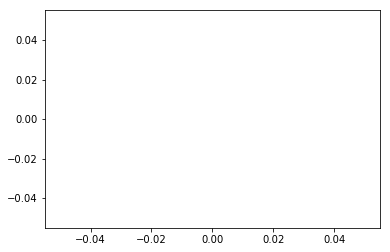

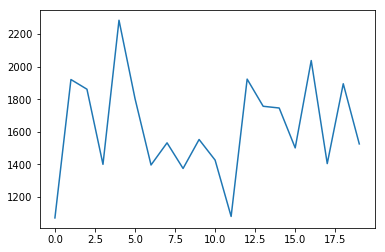

36964 61


In [90]:
import matplotlib.pyplot as plt
avg_scores = []
summ = 0
for index,value in enumerate(scores):
    if((index+1)%5==0):
        avg_scores.append(summ/50)
        summ=0
    summ+=value
plt.figure()
plt.plot(list(range(len(J)-1)),J[1:])
plt.show()
plt.plot(list(range(len(avg_scores))),avg_scores)
plt.show()
print(np.max(scores),np.argmax(scores))

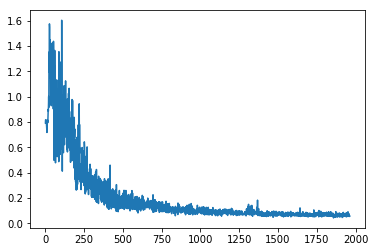

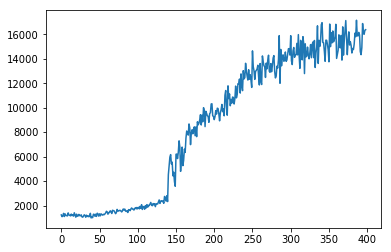

58380 16330


In [60]:
import matplotlib.pyplot as plt
avg_scores = []
summ = 0
for index,value in enumerate(scores):
    if((index+1)%50==0):
        avg_scores.append(summ/50)
        summ=0
    summ+=value
plt.figure()
plt.plot(list(range(len(J)-1)),J[1:])
plt.show()
plt.plot(list(range(len(avg_scores))),avg_scores)
plt.show()
print(np.max(scores),np.argmax(scores))

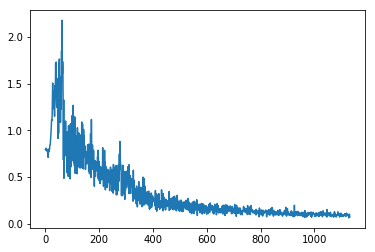

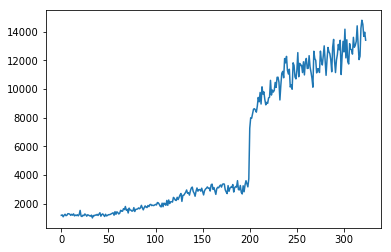

36044 13996


In [52]:
import matplotlib.pyplot as plt
avg_scores = []
summ = 0
for index,value in enumerate(scores):
    if((index+1)%50==0):
        avg_scores.append(summ/50)
        summ=0
    summ+=value
plt.figure()
plt.plot(list(range(len(J)-1)),J[1:])
plt.show()
plt.plot(list(range(len(avg_scores))),avg_scores)
plt.show()
print(np.max(scores),np.argmax(scores))

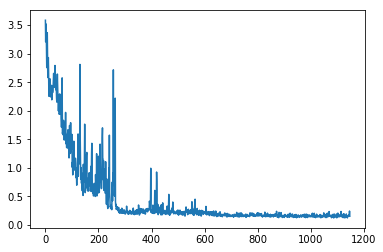

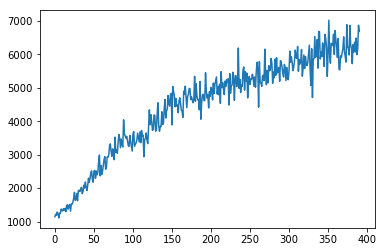

16524 16025


In [22]:
import matplotlib.pyplot as plt
avg_scores = []
summ = 0
for index,value in enumerate(scores):
    if((index+1)%50==0):
        avg_scores.append(summ/50)
        summ=0
    summ+=value
plt.figure()
plt.plot(list(range(len(J)-1)),J[1:])
plt.show()
plt.plot(list(range(len(avg_scores))),avg_scores)
plt.show()
print(np.max(scores),np.argmax(scores))

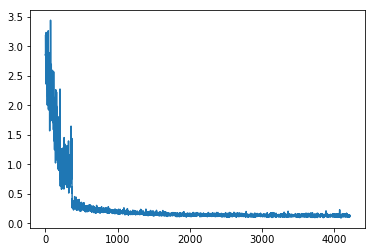

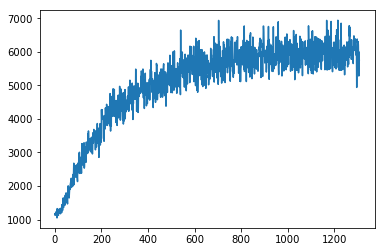

16576 60848


In [159]:
import matplotlib.pyplot as plt
avg_scores = []
summ = 0
for index,value in enumerate(scores):
    if((index+1)%50==0):
        avg_scores.append(summ/50)
        summ=0
    summ+=value
plt.figure()
plt.plot(list(range(len(J)-1)),J[1:])
plt.show()
plt.plot(list(range(len(avg_scores))),avg_scores)
plt.show()
print(np.max(scores),np.argmax(scores))

In [3]:
def new_game(n):
    matrix = []

    for i in range(n):
        matrix.append([0] * n)
    return matrix

def add_two(mat):
    empty_cells = []
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                empty_cells.append((i,j))
    if(len(empty_cells)==0):
        return mat
    index_pair = empty_cells[random.randint(0,len(empty_cells)-1)]
    
    #a=randint(0,len(mat)-1)
    #b=randint(0,len(mat)-1)
    #while(mat[a][b]!=0):
    #    a=randint(0,len(mat)-1)
    #    b=randint(0,len(mat)-1)
    mat[index_pair[0]][index_pair[1]]=2
    return mat

def game_state(mat):
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i][j]==2048:
                return 'win'
    for i in range(len(mat)-1): #intentionally reduced to check the row on the right and below
        for j in range(len(mat[0])-1): #more elegant to use exceptions but most likely this will be their solution
            if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                return 'not over'
    for i in range(len(mat)): #check for any zero entries
        for j in range(len(mat[0])):
            if mat[i][j]==0:
                return 'not over'
    for k in range(len(mat)-1): #to check the left/right entries on the last row
        if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
            return 'not over'
    for j in range(len(mat)-1): #check up/down entries on last column
        if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
            return 'not over'
    return 'lose'

def reverse(mat):
    new=[]
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0])-j-1])
    return new

def transpose(mat):
    new=[]
    for i in range(len(mat[0])):
        new.append([])
        for j in range(len(mat)):
            new[i].append(mat[j][i])
    return new

def cover_up(mat):
    new=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    done=False
    for i in range(4):
        count=0
        for j in range(4):
            if mat[i][j]!=0:
                new[i][count]=mat[i][j]
                if j!=count:
                    done=True
                count+=1
    return (new,done)

def merge(mat):
    done=False
    score = 0
    for i in range(4):
         for j in range(3):
             if mat[i][j]==mat[i][j+1] and mat[i][j]!=0:
                 mat[i][j]*=2
                 score += mat[i][j]   
                 mat[i][j+1]=0
                 done=True
    return (mat,done,score)


def up(game):
        #print("up")
        # return matrix after shifting up
        game=transpose(game)
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=transpose(game)
        return (game,done,temp[2])

def down(game):
        #print("down")
        game=reverse(transpose(game))
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=transpose(reverse(game))
        return (game,done,temp[2])

def left(game):
        #print("left")
        # return matrix after shifting left
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        return (game,done,temp[2])

def right(game):
        #print("right")
        # return matrix after shifting right
        game=reverse(game)
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=reverse(game)
        return (game,done,temp[2])
    

def findemptyCell(mat):
    count = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                count+=1
    return count

In [75]:
final_parameters['layer3_b']

array([ 0.20456064,  0.19440305,  0.18357074,  0.16707523], dtype=float32)

In [76]:
prev_paramters = deepcopy(final_parameters)

In [77]:
prev_paramters['layer3_b']

array([ 0.20456064,  0.19440305,  0.18357074,  0.16707523], dtype=float32)